# Detecting Potholes in the Wild

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output

from torch.utils.data import random_split

In [2]:
pip install pascal-voc-writer

Note: you may need to restart the kernel to use updated packages.


In [3]:
data_path = '02516_pothole_w3/data/Potholes/annotated-images'

In [4]:
import os

 # Replace this with your folder path
# List all files and directories in the specified folder
contents = os.listdir(data_path)

# Print the list of contents
#print("Contents of the folder:")
#for item in contents:
#    print(item)

In [5]:
import xml.etree.ElementTree as ET


def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes

In [6]:
_, box = read_content('02516_pothole_w3/data/Potholes/annotated-images/img-1.xml')
print(torch.tensor(box))

tensor([[213, 240, 525, 378]])


In [7]:
class PhC(torch.utils.data.Dataset):
    def __init__(self, transform, data_path=data_path):
        'Initialization'
        self.transform = transform
        self.image_paths = sorted(glob.glob(data_path + '/*.jpg'))
        self.box_paths = sorted(glob.glob(data_path + '/*.xml'))
    
    def __len__(self):
        'Returns the total number of samples'
        return len(self.box_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        box_path = self.box_paths[idx]

        image = Image.open(image_path)
        im_name, box = read_content(box_path)
        Y = torch.tensor(box)
        X = self.transform(image)

        # Pad with zeros to have a fixed size of max_boxes x 4
        max_boxes = 20  # Change this to the maximum number of boxes you expect
        current_size = Y.size(0)

        if current_size < max_boxes:
            # Pad with zeros if the size is less than max_boxes
            padding = torch.zeros(max_boxes - current_size, 4, dtype=torch.float32)
            Y = torch.cat((Y, padding))

        X = self.transform(image)
        return X, Y


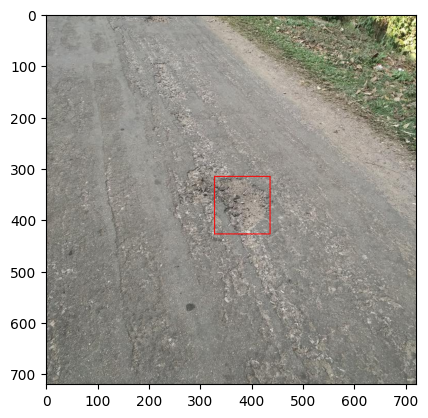

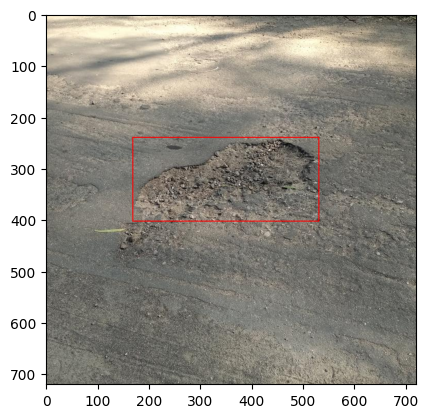

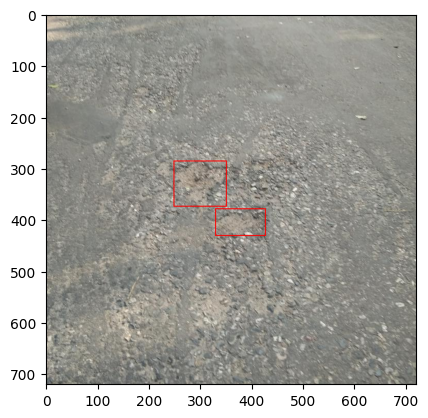

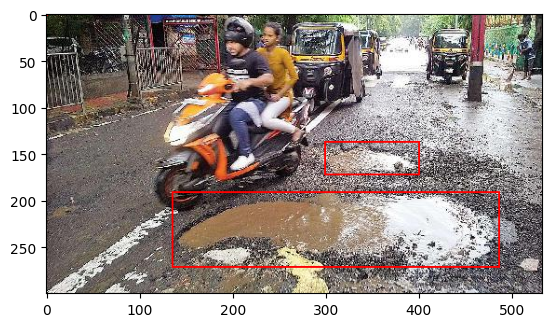

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


size = 128
# Define the transform with resizing and center cropping
train_transform = transforms.Compose([
    transforms.ToTensor()
])

# Create PH2 dataset
dataset = PhC(transform=train_transform, data_path=data_path)

# Custom collate function
def my_collate(batch):
    images, boxes = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, boxes

# Create data loader with custom collate function
batch_size = 1
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=3, collate_fn=my_collate)

# Set the maximum number of images to display
max_images_to_display = 4

# Counter for displayed images
displayed_images = 0

# Iterate over the DataLoader
for images, boxes in train_loader:
    # Convert the images to numpy arrays
    images_np = images.permute(0, 2, 3, 1).numpy()

    # Iterate over each sample in the batch
    for i in range(batch_size):
        if displayed_images >= max_images_to_display:
            break

        image_np = images_np[i]
        boxes_sample = boxes[i]

        # Create a PIL image from the numpy array
        image_pil = Image.fromarray((image_np * 255).astype('uint8'))

        # Create a draw object to draw bounding boxes on the image
        draw = ImageDraw.Draw(image_pil)

        # Iterate over each bounding box in the sample
        for box in boxes_sample:
            # Draw the bounding box on the image
            draw.rectangle([box[0], box[1], box[2], box[3]], outline='red', width=2)

        # Show the image with bounding boxes
        plt.imshow(image_pil)
        plt.show()

        # Increment the counter
        displayed_images += 1

    # Break out of the outer loop if the desired number of images is displayed
    if displayed_images >= max_images_to_display:
        break


In [9]:
pip install opencv-contrib-python numpy

Note: you may need to restart the kernel to use updated packages.


(1387, 4)


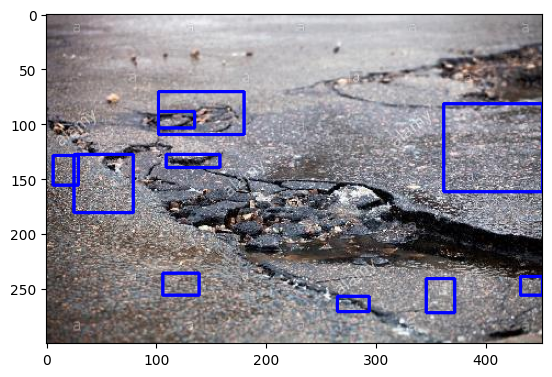

In [10]:
import cv2
from matplotlib import pyplot as plt

# Load an image using OpenCV
image_path = '02516_pothole_w3/data/Potholes/annotated-images/img-631.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Create a Selective Search segmentation object
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

# Set the input image
ss.setBaseImage(image)

# Perform selective search
ss.switchToSelectiveSearchFast()
rectangles = ss.process()
print(rectangles.shape)


# Visualize the selective search rectangles
image_vis = image_rgb.copy()
for (x, y, w, h) in rectangles[:10]:  # Show only the first 6 proposals
    cv2.rectangle(image_vis, (x, y), (x + w, y + h), (0, 0, 255), 2)

# Display the image with selective search rectangles
plt.imshow(image_vis)
plt.show()


In [11]:
def selective_search(image, method="fast"):
    # image = cv2.imread(image_path)
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    ss.setBaseImage(image)

    if method == "fast":
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()
    rects = ss.process()
    return rects

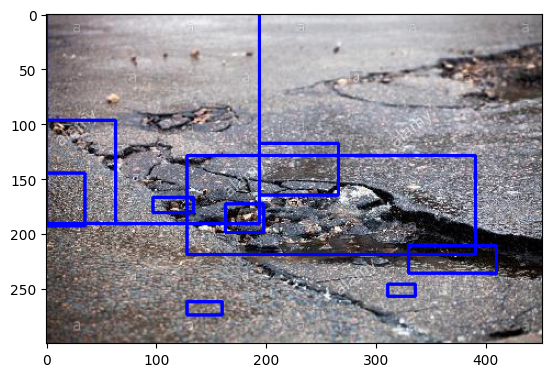

In [12]:
selective_search(image)

image_vis = image_rgb.copy()
for (x, y, w, h) in selective_search(image)[:10]:  # Show only the first 6 proposals
    cv2.rectangle(image_vis, (x, y), (x + w, y + h), (0, 0, 255), 2)

# Display the image with selective search rectangles
plt.imshow(image_vis)
plt.show()

In [13]:
# Load an image using OpenCV
image_path = '02516_pothole_w3/data/Potholes/annotated-images/img-631.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

(300, 452, 3)


In [14]:
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.

    Parameters:
    - box1, box2: Bounding boxes in the format (x, y, width, height)

    Returns:
    - IoU score
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate coordinates of intersection rectangle
    x_intersection = max(x1, x2)
    y_intersection = max(y1, y2)
    w_intersection = min(x1 + w1, x2 + w2) - x_intersection
    h_intersection = min(y1 + h1, y2 + h2) - y_intersection

    # Check for no overlap
    if w_intersection <= 0 or h_intersection <= 0:
        return 0.0

    # Calculate area of intersection and union
    area_intersection = w_intersection * h_intersection
    area_union = w1 * h1 + w2 * h2 - area_intersection

    # Calculate IoU
    iou = area_intersection / area_union

    return iou

In [15]:
def label_proposals(all_proposals, labels, max_threshold_iou=0.5):
    best_bbs = []
    for label in labels[0]:
        best_bb = (None, "pothole")
        max_iou = max_threshold_iou
        for proposal in all_proposals:
            iou = calculate_iou(proposal, label)
            if iou > max_iou:
                max_iou = iou
                best_bb = (proposal, "pothole")
        best_bbs.append(best_bb)
    return best_bbs

In [16]:
image, labels = next(iter(train_loader))
image = image.squeeze().permute(1, 2, 0).numpy()
all_proposals = selective_search(image, method="notsofast")
best_bbs = label_proposals(all_proposals, labels)
print(best_bbs)

[(None, 'pothole'), (array([ 42, 116, 228, 116], dtype=int32), 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole')]


In [17]:
id = 0
images = []
labels_s = []
best_bbs_s = []
for image, labels in train_loader:
    id += 1
    if id == 6:
        break
    image = image.squeeze().permute(1, 2, 0).numpy()
    all_proposals = selective_search(image, method="notsofast")
    
    best_bbs = label_proposals(all_proposals, labels)
    best_bbs_s.append(best_bbs)
    images.append(image)
    labels_s.append(labels)

In [18]:
print(best_bbs_s)
print(labels_s)

[[(array([ 34, 137, 266, 232], dtype=int32), 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole')], [(array([333, 257, 308, 398], dtype=int32), 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothole')], [(array([  0,  95, 191, 205], dtype=int32), 'pothole'), (array([ 86,  37, 514, 263], dtype=int32), 'pothole'), (None, 'pothole'), (None, 'pothole'), (None, 'pothol

In [19]:
clean = [[item for item in sublist if item[0] is not None] for sublist in best_bbs_s]

print(clean)

[[(array([ 34, 137, 266, 232], dtype=int32), 'pothole')], [(array([333, 257, 308, 398], dtype=int32), 'pothole')], [(array([  0,  95, 191, 205], dtype=int32), 'pothole'), (array([ 86,  37, 514, 263], dtype=int32), 'pothole')], [(array([ 96,  81, 504, 219], dtype=int32), 'pothole')], [(array([  0, 100, 531, 200], dtype=int32), 'pothole')]]


Rectangle(xy=(71, 136), width=236, height=212, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=

AttributeError: 'numpy.ndarray' object has no attribute 'add_patch'

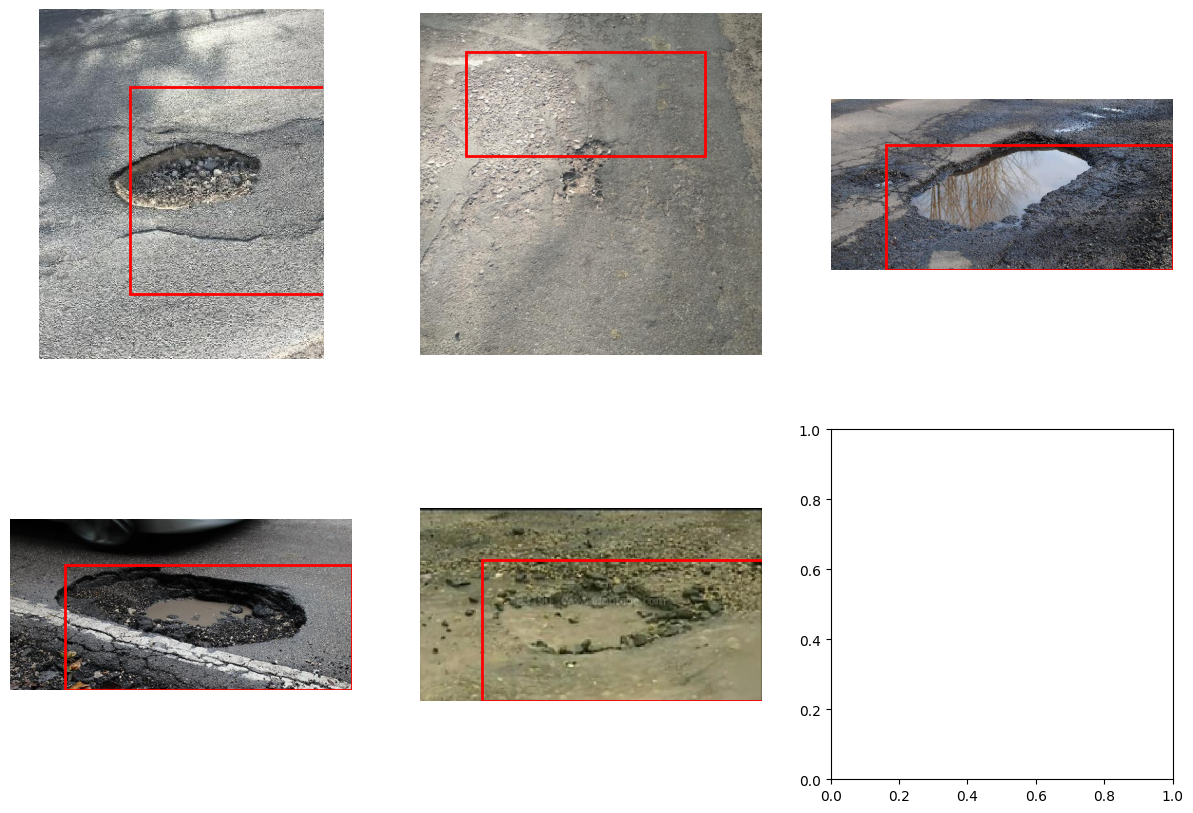

In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

# Load the image
# img_path = "data/Potholes/annotated-images/img-631.jpg"  # Replace with the path to your actual image
# img = mpimg.imread(img_path)

# Create figure and axes

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, img in enumerate(images):    
    axes[idx].imshow(img)
    axes[idx].axis('off')

    cur_bbs = best_bbs_s[3]
    
    for bbs in cur_bbs:
        cords = bbs[0]
        if cords is not None:
            rect = patches.Rectangle((cords[0], cords[1]), cords[2], cords[3], linewidth=2, edgecolor='r', facecolor='none')
            axes[idx].add_patch(rect)
            
    labels = labels_s[idx]
    for label in labels[0]:
        rect = patches.Rectangle((label[0], label[1]), label[2], label[3], linewidth=2, edgecolor='g', facecolor='none')
        print(rect)
    axes[idx].add_patch(rect)

# Add the rectangle to the Axes
axes.add_patch(rect)

# Show the plot
plt.tight_layout()
plt.show()
